In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, truncexpon, truncnorm, nbinom, norm
import pandas as pd
import time
import torch
from torch import nn
from torch import distributions
from torch import rand
from torch import autograd
from torch import optim
import torch.nn as nn

In [2]:
def bij_transform(prime, lower, upper):
    # Recieves a value in [-inf, inf] and returns value in [low, upper]
    bij = 1 / (1 + torch.exp(-prime / upper))
    scale = upper - lower
    return scale * bij + lower

def bij_transform_inv(transf, lower, upper):
    return -torch.log(((upper - lower) / (transf - lower) - 1) ** upper)

def bij_transform_inf(prime):
    return torch.exp(prime)

In [3]:
np.random.seed(seed=101)
torch.manual_seed(101)
dtype = torch.float64
device = torch.device("cpu")

In [4]:
data = pd.read_csv('covid19model.csv')

Initialization

In [5]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

In [6]:
# Use Toy Data
#toy_data = pd.read_csv('data/toy_data_2.csv')
#toy_data_np = toy_data['0'].round()
#plt.plot(toy_data_np)
#observed_daily_hospit = torch.tensor(toy_data_np, requires_grad=False, device=device, dtype=dtype)

In [7]:
tau_prime = torch.tensor(bij_transform_inv(torch.tensor(30), 0, 100), requires_grad=True, device=device, dtype=dtype)
R0_prime = torch.tensor(bij_transform_inv(torch.tensor(3.6), 2, 5), requires_grad=True, device=device, dtype=dtype)
phi_prime = torch.tensor(bij_transform_inv(torch.tensor(25), 0, 50), requires_grad=True, device=device, dtype=dtype)
alpha_prime = torch.tensor(bij_transform_inv(torch.tensor(0.01), 0.00001, 0.05), requires_grad=True, device=device, dtype=dtype)
sigma_prime = torch.tensor(bij_transform_inv(torch.tensor(0.1), 0.00001, 0.5), requires_grad=True, device=device, dtype=dtype)
sigma = bij_transform(sigma_prime, 0.00001, 0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy 

In [8]:
epsilon_t = torch.zeros(num_observations, device=device)
epsilon_t[0] = torch.distributions.Normal(cero, sigma.detach()).rsample()
for t in range(1, num_observations):
    epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].detach(), sigma.detach()).rsample()
epsilon_t.requires_grad_(True)

tensor([-0.1391, -0.2206, -0.2526, -0.1788, -0.3542, -0.2939, -0.3190, -0.3628,
        -0.4201, -0.7403, -0.6840, -0.6624, -0.8820, -0.9037, -0.9763, -0.7917,
        -0.7668, -0.7390, -0.5772, -0.6006, -0.7345, -0.7407, -0.7676, -0.6777,
        -0.5977, -0.6490, -0.6907, -0.6058, -0.4073, -0.5343, -0.4445, -0.3381,
        -0.4099, -0.2961, -0.4642, -0.4552, -0.4716, -0.5728, -0.5334, -0.4756,
        -0.3396, -0.3782, -0.4383, -0.5820, -0.5642, -0.6591, -0.6684, -0.5522,
        -0.6782, -0.5961, -0.5440, -0.5347, -0.4352, -0.5329, -0.3895, -0.3714,
        -0.3615, -0.2182, -0.1901, -0.1505, -0.0678, -0.0836, -0.0150,  0.0303,
        -0.0118,  0.0317,  0.0841, -0.0874, -0.2155, -0.4036, -0.5561, -0.5759,
        -0.5243, -0.6334, -0.6586, -0.7501, -0.8969, -0.9205, -0.9040, -0.9072,
        -0.9416, -1.0492, -1.1803, -1.1975, -1.3783, -1.4242, -1.4823, -1.4366,
        -1.4896, -1.5624, -1.4378, -1.3956, -1.3733, -1.3770, -1.2289, -1.0941,
        -1.2038, -1.0577, -0.9475, -0.70

In [9]:
dist_tau = distributions.exponential.Exponential(torch.tensor([1 / 0.03], device=device))

dist_phi = distributions.normal.Normal(loc=torch.tensor([25], device=device), scale=torch.tensor([10], device=device))

dist_R0 = distributions.normal.Normal(loc=torch.tensor([3.6], device=device), scale=torch.tensor([0.8], device=device))

dist_alpha = distributions.normal.Normal(loc=torch.tensor([0.01], device=device),
                                         scale=torch.tensor([0.01], device=device))

dist_sigma = distributions.normal.Normal(loc=torch.tensor([0.1], device=device),
                                         scale=torch.tensor([0.3], device=device))

Forward Pass

In [10]:
def calc_prior_loss(tau, phi, R0, alpha, sigma):
    # log likelihood wrt. our prior ("regularisation")
    # ll stands for log-likelihood
    ll = torch.tensor(0.0, device=device)

    ll += dist_tau.log_prob(tau)[0]  # TODO

    ll += dist_phi.log_prob(phi)[0]

    ll += dist_R0.log_prob(R0)[0]

    ll += dist_alpha.log_prob(alpha)[0]

    ll += dist_sigma.log_prob(sigma)[0]

    return -ll

In [11]:
def seed_init_infect(y):
    # Initialize newly_infected, cumulative_infected, St
    newly_infected = torch.zeros(num_observations, device=device, dtype=dtype)  # number of newly infected
    cumulative_infected = torch.zeros(num_observations, device=device)  # cumulative number of infected

    St = torch.zeros(num_observations, device=device)  # fraction of susceptible population
    # seed initial infection / impute first num_impute days
    newly_infected[0:num_impute] = y.clone()
    cumulative_infected[0] = 0.
    cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
    St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in
                                     cumulative_infected[0:num_impute].clone()])
    return newly_infected, cumulative_infected, St

In [12]:
def calc_Rt(R0, epsilon_t, sigma, ll):
    # Initialize eta_t
    eta_t = torch.zeros(num_observations, device=device)  # transformed reproduction number
    # calculate Rt: the basic reproduction number
    # basic reproduction number as a latent random walk
    beta_0 = torch.log(R0)
    eta_t[0] = beta_0

    loc = epsilon_t[:-1].clone()
    scale = sigma * torch.ones(num_observations - 1)
    mvn = distributions.multivariate_normal.MultivariateNormal(loc, scale_tril=torch.diag(scale))
    ll += mvn.log_prob(epsilon_t[1:].clone())

    eta_t[1:num_observations] = epsilon_t[0:num_observations - 1].clone() + beta_0
    Rt = torch.exp(eta_t)
    ll = (-1) * ll
    return Rt, ll

In [13]:
def calc_infections(cumulative_infected, newly_infected, St, Rt):
    # Initialize effectively_infectious
    effectively_infectious = torch.zeros(num_observations, device=device)  # effective number of infectious individuals

    # calculate infections
    for t in range(num_impute, num_observations):
        # Update cumulative newly_infected
        cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
        # Adjusts for portion of pop that are susceptible
        St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
        # effective number of infectous individuals
        ni_temp = newly_infected[:t].view(1, 1, -1).clone()
        si_temp = torch.flip(serial_interval, (0,))[-t:].view(1, 1, -1)
        effectively_infectious[t] = torch.nn.functional.conv1d(ni_temp, si_temp)

        newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()
    return newly_infected

In [14]:
def calc_hospit(newly_infected, alpha):
    # Initialize expected_daily_hospit
    expected_daily_hospit = torch.zeros(num_observations, device=device)  # expected number of daily hospitalizations

    # calculate expected number of hospitalizations
    expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
    for t in range(1, num_observations):
        ni_temp = newly_infected[:t].view(1, 1, -1)
        pi_temp = torch.flip(pi, (0,))[-t - 1:-1].view(1, 1, -1)
        expected_daily_hospit[t] = torch.nn.functional.conv1d(ni_temp, pi_temp)
    expected_daily_hospit = alpha * expected_daily_hospit
    return expected_daily_hospit

In [15]:
def compare_results(expected_daily_hospit, phi, ll):
    # compare observed hospitalizations to model results
    # likelihood of the data wrt. to the model
    p = 1 / (1 + expected_daily_hospit/ phi)
    dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p)
    ll = dist.log_prob(observed_daily_hospit).sum()

    ll = (-1) * ll

    return ll

In [16]:
def compare_results_abs(expected_daily_hospit, phi, ll):
    # compare observed hospitalizations to model results
    # likelihood of the data wrt. to the model

    diff = expected_daily_hospit - observed_daily_hospit
    square = diff.square()
    msr = square.mean()
    ll += msr

    return ll

In [17]:
def forward_pass():
    # Initialize y
    tau = bij_transform(tau_prime, 0, 100)
    y = torch.distributions.exponential.Exponential(1 / tau).rsample()
    R0 = bij_transform(R0_prime, lower=2, upper=5)
    phi = bij_transform(phi_prime, lower=0.00001, upper=50)
    alpha = bij_transform(alpha_prime, lower=0.00001, upper=0.05)
    sigma = bij_transform(sigma_prime, lower=0.00001, upper=0.5)

    # Calculate prior loss
    ll_prior = calc_prior_loss(tau, phi, R0, alpha, sigma)

    # Seed initial infections
    newly_infected, cumulative_infected, St = seed_init_infect(y)

    # Calculate Rt & random walk loss
    Rt, ll_rw = calc_Rt(R0, epsilon_t, sigma, torch.tensor(0.0, device=device))  ##ll

    # Calculate infections
    newly_infected = calc_infections(cumulative_infected, newly_infected, St, Rt)

    # Calculate expected hospitalizations
    expected_daily_hospit = calc_hospit(newly_infected, alpha)


    # Compare observed hospitalizations to model results
    ll_comp = compare_results_abs(expected_daily_hospit, phi, torch.tensor(0.0, device=device))  ##ll

    return expected_daily_hospit, Rt, ll_prior, ll_rw, ll_comp, tau, R0, phi, alpha, sigma


Optimization


Prior Loss:996.439453125  Random Walk Loss:-369.9466552734375 Comparison Loss:164691.140625 


Time Step: 0 || Loss: 164691.140625 || Learning Rate: 0.01

R0:3.599999794528343  grad:29262.66220702287
alpha:0.010000003833702966  grad:5249021.771625055
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.12917691469192505  grad.mean:1733.265625
tau:29.999999224015074  grad:227.2127234269436

This Run:  0.2510986328125 seconds


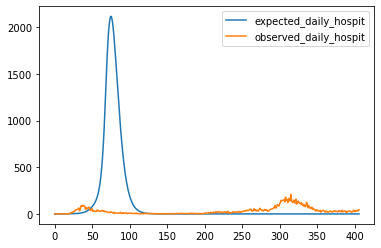

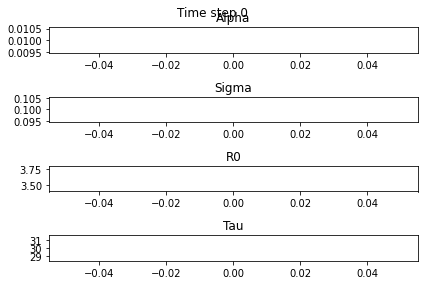


Prior Loss:994.8579711914062  Random Walk Loss:-359.98431396484375 Comparison Loss:765.3856201171875 


Time Step: 500 || Loss: 765.3856201171875 || Learning Rate: 0.01

R0:3.5511421294892735  grad:123.0745226847926
alpha:0.0015616681391836089  grad:7687.540540070247
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.40081581473350525  grad.mean:7.167301654815674
tau:29.941819752539377  grad:2.1160055430090914

This Run:  0.21268606185913086 seconds


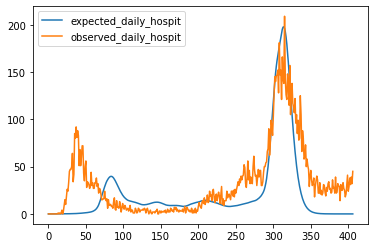


Prior Loss:994.3334350585938  Random Walk Loss:-271.0986328125 Comparison Loss:479.53521728515625 


Time Step: 1000 || Loss: 479.53521728515625 || Learning Rate: 0.01

R0:3.5358725615769995  grad:-55.210043841040545
alpha:0.0014550058617119035  grad:-3021.8763059934963
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.5054922103881836  grad.mean:-3.1994659900665283
tau:29.92576936468727  grad:-0.5606148097200867

This Run:  0.27432823181152344 seconds


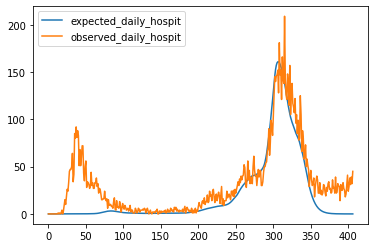


Prior Loss:994.324462890625  Random Walk Loss:808.9580688476562 Comparison Loss:578.2927856445312 


Time Step: 1500 || Loss: 578.2927856445312 || Learning Rate: 0.01

R0:3.5352997004556928  grad:184.51229797316597
alpha:0.0013405291240892704  grad:-11053.1738178554
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.47815585136413574  grad.mean:10.69070816040039
tau:29.925205625519673  grad:0.172537414395069

This Run:  0.21464800834655762 seconds


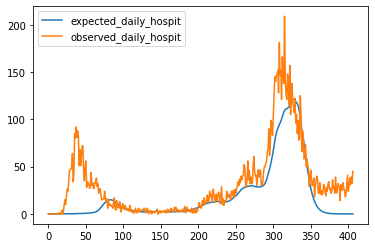


Prior Loss:994.439697265625  Random Walk Loss:1063.219482421875 Comparison Loss:570.0640258789062 


Time Step: 2000 || Loss: 570.0640258789062 || Learning Rate: 0.01

R0:3.535655655275494  grad:-127.11857675012342
alpha:0.001404689387437531  grad:8212.621094140142
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.4769532382488251  grad.mean:-7.366119861602783
tau:29.928826421588333  grad:-0.9692376865304846

This Run:  0.21501827239990234 seconds


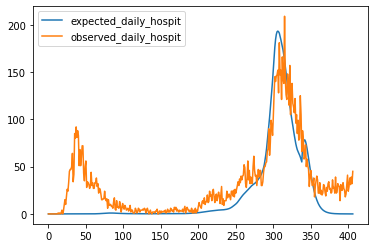


Prior Loss:994.5421142578125  Random Walk Loss:1161.1025390625 Comparison Loss:502.6930847167969 


Time Step: 2500 || Loss: 502.6930847167969 || Learning Rate: 0.01

R0:3.5352842681933216  grad:247.06901438131558
alpha:0.0014082470311261913  grad:-9273.242689270946
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.4775081276893616  grad.mean:14.315196990966797
tau:29.931907494610904  grad:0.4842161985110261

This Run:  0.2108321189880371 seconds


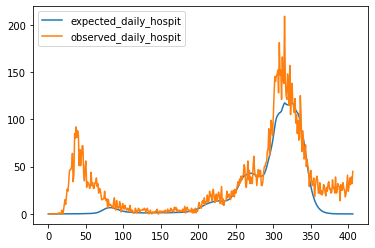


Prior Loss:994.7164916992188  Random Walk Loss:1202.30224609375 Comparison Loss:501.1959228515625 


Time Step: 3000 || Loss: 501.1959228515625 || Learning Rate: 0.01

R0:3.5351857667413755  grad:-55.738713176209544
alpha:0.0013437277691082875  grad:-476.0992516992224
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.4797933101654053  grad.mean:-3.229405164718628
tau:29.93697133236639  grad:-0.5526441386424057

This Run:  0.2140800952911377 seconds


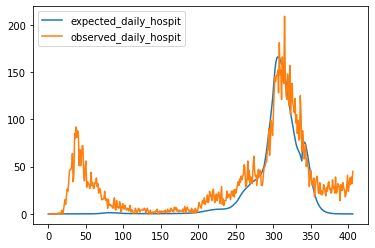


Prior Loss:995.0348510742188  Random Walk Loss:1313.28369140625 Comparison Loss:845.6665649414062 


Time Step: 3500 || Loss: 845.6665649414062 || Learning Rate: 0.01

R0:3.5377442826279357  grad:-327.9971586842754
alpha:0.0015051700935693726  grad:31465.53599160238
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.4746965169906616  grad.mean:-19.018922805786133
tau:29.94694720715327  grad:-1.8100745381796788

This Run:  0.2124190330505371 seconds


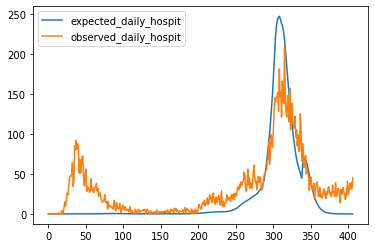


Prior Loss:995.2697143554688  Random Walk Loss:1374.869140625 Comparison Loss:522.9143676757812 


Time Step: 4000 || Loss: 522.9143676757812 || Learning Rate: 0.01

R0:3.5354530557121606  grad:-224.01679753052127
alpha:0.0015428868309889782  grad:10872.945847995043
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.4814562201499939  grad.mean:-12.98023796081543
tau:29.954082516374207  grad:-1.2114009465686297

This Run:  0.21135234832763672 seconds


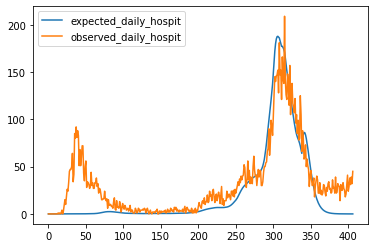


Prior Loss:995.6380615234375  Random Walk Loss:1333.36181640625 Comparison Loss:460.7112121582031 


Time Step: 4500 || Loss: 460.7112121582031 || Learning Rate: 0.01

R0:3.536887320260758  grad:-88.8891958809273
alpha:0.0015524875304872  grad:2156.716904758946
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.47898927330970764  grad.mean:-5.152846813201904
tau:29.965161302569022  grad:-0.7747228518368686

This Run:  0.21544957160949707 seconds


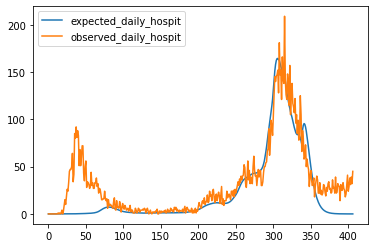


Prior Loss:995.649658203125  Random Walk Loss:1402.25 Comparison Loss:437.02520751953125 


Time Step: 5000 || Loss: 437.02520751953125 || Learning Rate: 0.01

R0:3.5324076419318464  grad:41.163504445972094
alpha:0.0014221098540840719  grad:-6042.813965064361
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.48047932982444763  grad.mean:2.3828694820404053
tau:29.96516440999069  grad:-0.02729882057065306

This Run:  0.21269536018371582 seconds


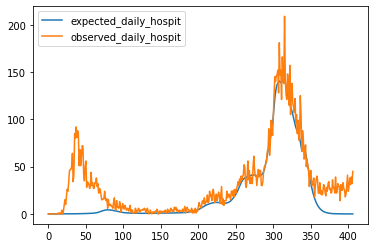

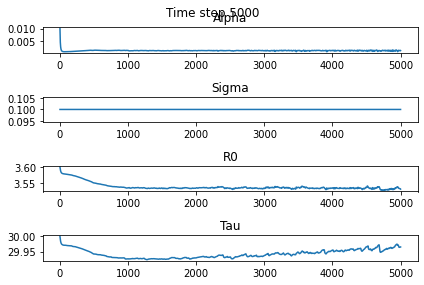


Prior Loss:996.2273559570312  Random Walk Loss:1573.3984375 Comparison Loss:562.0279541015625 


Time Step: 5500 || Loss: 562.0279541015625 || Learning Rate: 0.01

R0:3.533217803375574  grad:-102.95113202242048
alpha:0.001336682828376802  grad:4309.486630310479
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.48099085688591003  grad.mean:-5.961134433746338
tau:29.982275576299095  grad:-0.849478566106808

This Run:  0.22645854949951172 seconds


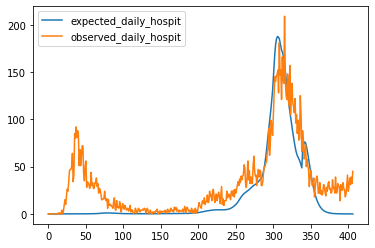


Prior Loss:996.6593627929688  Random Walk Loss:1598.0498046875 Comparison Loss:461.00494384765625 


Time Step: 6000 || Loss: 461.00494384765625 || Learning Rate: 0.01

R0:3.5323034665249486  grad:101.83928286478567
alpha:0.0013602047069363407  grad:-8975.59623710169
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.4804452061653137  grad.mean:5.8950724601745605
tau:29.995291299636413  grad:0.04535870267106814

This Run:  0.21355557441711426 seconds


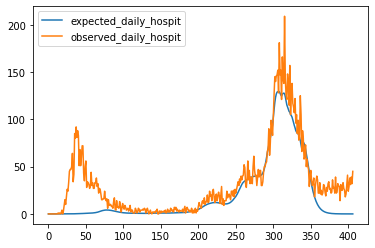


Prior Loss:997.1212158203125  Random Walk Loss:1503.265869140625 Comparison Loss:495.78521728515625 


Time Step: 6500 || Loss: 495.78521728515625 || Learning Rate: 0.01

R0:3.5317132807300586  grad:143.3314745870617
alpha:0.0012820767593399222  grad:-10624.831887333485
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.48151370882987976  grad.mean:8.295365333557129
tau:30.00894072953916  grad:0.21208363940405892

This Run:  0.21253299713134766 seconds


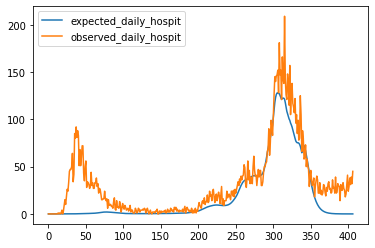


Prior Loss:997.6371459960938  Random Walk Loss:1402.482421875 Comparison Loss:575.04833984375 


Time Step: 7000 || Loss: 575.04833984375 || Learning Rate: 0.01

R0:3.5317691165447354  grad:285.38552800551184
alpha:0.0012843037393402792  grad:-14243.572623759897
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.4741930067539215  grad.mean:16.517086029052734
tau:30.024427093887272  grad:0.27301171440245847

This Run:  0.2133936882019043 seconds


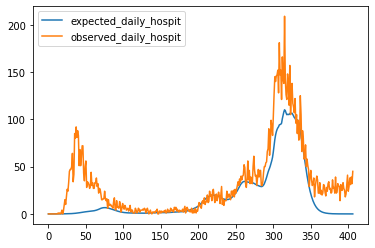


Prior Loss:998.495361328125  Random Walk Loss:1650.672607421875 Comparison Loss:390.07403564453125 


Time Step: 7500 || Loss: 390.07403564453125 || Learning Rate: 0.01

R0:3.528979756970326  grad:-36.67407874032601
alpha:0.0015607307977549502  grad:-573.4593144987349
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.4914596378803253  grad.mean:-2.120727300643921
tau:30.050876773908993  grad:-0.01132268185542976

This Run:  0.21450090408325195 seconds


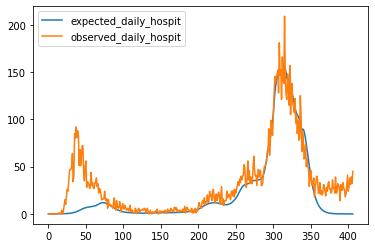


Prior Loss:999.2302856445312  Random Walk Loss:1603.29541015625 Comparison Loss:441.6453552246094 


Time Step: 8000 || Loss: 441.6453552246094 || Learning Rate: 0.01

R0:3.531038253345532  grad:-49.626295850867244
alpha:0.001540197149786849  grad:1261.7765213016946
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.48208776116371155  grad.mean:-2.8715381622314453
tau:30.072878642311764  grad:1.9260234200992408

This Run:  0.21692252159118652 seconds


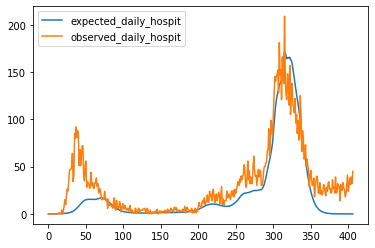


Prior Loss:999.564453125  Random Walk Loss:1623.521240234375 Comparison Loss:474.0627136230469 


Time Step: 8500 || Loss: 474.0627136230469 || Learning Rate: 0.01

R0:3.5308441481648787  grad:202.24325551914083
alpha:0.001390321673431624  grad:-12713.130180885888
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.48040011525154114  grad.mean:11.701744079589844
tau:30.08251984545488  grad:-0.4124041334871331

This Run:  0.21524477005004883 seconds


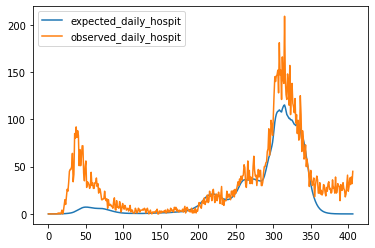


Prior Loss:1000.2029418945312  Random Walk Loss:1811.221435546875 Comparison Loss:422.2972717285156 


Time Step: 9000 || Loss: 422.2972717285156 || Learning Rate: 0.01

R0:3.5293643564652037  grad:144.2483520665034
alpha:0.0014865782851267583  grad:-7700.6861676723265
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.4856627881526947  grad.mean:8.342345237731934
tau:30.10191442530082  grad:-0.34054371339440803

This Run:  0.21193623542785645 seconds


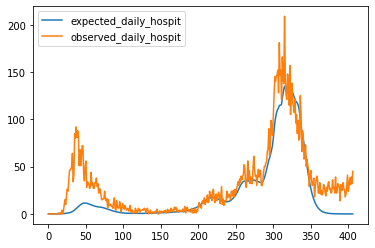


Prior Loss:1000.3418579101562  Random Walk Loss:1883.360595703125 Comparison Loss:1825.3270263671875 


Time Step: 9500 || Loss: 1825.3270263671875 || Learning Rate: 0.01

R0:3.525723149721531  grad:-1085.714967711208
alpha:0.0016328225620655928  grad:86499.45826332502
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.49362847208976746  grad.mean:-62.720008850097656
tau:30.10643927305973  grad:-4.0805588021885235

This Run:  0.2139594554901123 seconds


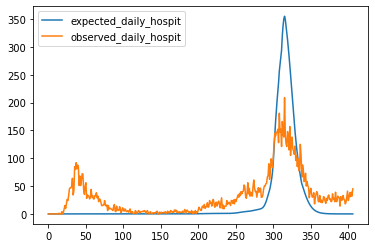


Prior Loss:1001.18408203125  Random Walk Loss:1871.59619140625 Comparison Loss:602.38037109375 


Time Step: 10000 || Loss: 602.38037109375 || Learning Rate: 0.01

R0:3.5311858345968714  grad:-383.9274465170186
alpha:0.0016489971912236401  grad:16961.683807977475
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.48559412360191345  grad.mean:-22.216304779052734
tau:30.1317659607127  grad:-1.956458819599837

This Run:  0.22056055068969727 seconds


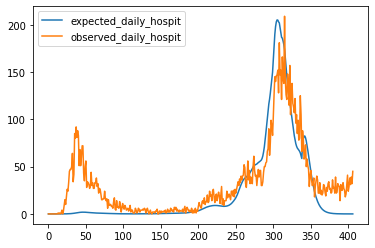

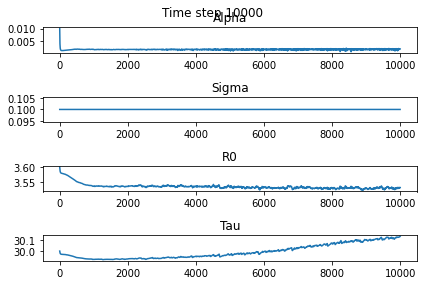


Prior Loss:1001.3522338867188  Random Walk Loss:1982.1025390625 Comparison Loss:425.82672119140625 


Time Step: 10500 || Loss: 425.82672119140625 || Learning Rate: 0.01

R0:3.528149663977112  grad:161.52569444091475
alpha:0.0014291856630471078  grad:-9707.99382788145
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.49394193291664124  grad.mean:9.338044166564941
tau:30.136241711533664  grad:-0.32159136346588935

This Run:  0.21750164031982422 seconds


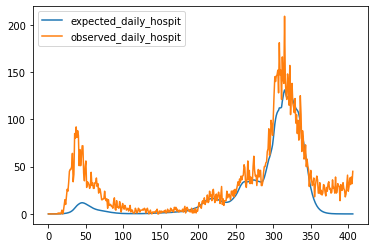


Prior Loss:1001.6837768554688  Random Walk Loss:1976.977294921875 Comparison Loss:389.3287353515625 


Time Step: 11000 || Loss: 389.3287353515625 || Learning Rate: 0.01

R0:3.531971929866093  grad:150.47815687882115
alpha:0.0016251250131946388  grad:-4907.55338478934
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.4859275817871094  grad.mean:8.709683418273926
tau:30.14669976027325  grad:-0.8717728957192769

This Run:  0.21675992012023926 seconds


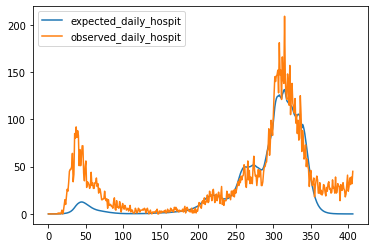


Prior Loss:1001.5006713867188  Random Walk Loss:2075.2509765625 Comparison Loss:493.1317138671875 


Time Step: 11500 || Loss: 493.1317138671875 || Learning Rate: 0.01

R0:3.527051930413739  grad:-125.74980924645851
alpha:0.001521641608251561  grad:2847.79273489013
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.487746924161911  grad.mean:-7.26732873916626
tau:30.140930821034484  grad:-0.970820764359834

This Run:  0.21091318130493164 seconds


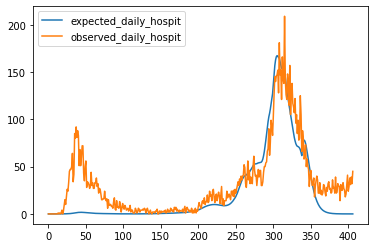


Prior Loss:1001.57177734375  Random Walk Loss:1983.37109375 Comparison Loss:422.0747985839844 


Time Step: 12000 || Loss: 422.0747985839844 || Learning Rate: 0.01

R0:3.5273005517201588  grad:176.8338525156767
alpha:0.0014951681735406548  grad:-10205.313969889365
phi:25.000004999999998  grad:None
sigma:0.10000000830384637  grad:None
epsilon_t.mean:-0.4902547001838684  grad.mean:10.220357894897461
tau:30.142995160875223  grad:-0.5908707364950618

This Run:  0.2242746353149414 seconds


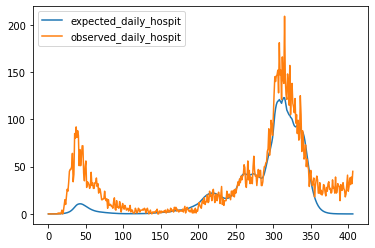

KeyboardInterrupt: ignored

In [18]:
# Visualization initialization
alpha_vis = []
sigma_vis = []
R0_vis = []
tau_vis = []
phi_vis = []
epsilon_mean_vis = []
loss_vis = []
prior_loss_vis = []
rw_loss_vis = []
comp_loss_vis = []
learning_rate_vis = []

learning_rate = 1e-2
epochs = 20000
complete_time = time.time()

var_list = [tau_prime, phi_prime, R0_prime, alpha_prime, sigma_prime, epsilon_t]
optimizer = optim.Adam(var_list, lr=learning_rate)

for k in range(epochs):
    optimizer.zero_grad()
    start_time = time.time()

    # forward pass - calculate expected_daily_hospit
    expected_daily_hospit, Rt, ll_prior, ll_rw, ll_comp, tau, R0, phi, alpha, sigma = forward_pass()

    # backward pass
    loss = ll_comp  # + ll_rw # + ll_prior

    loss.backward()

    if k % 500 == 0:
        print(
            f'\nPrior Loss:{ll_prior}  Random Walk Loss:{ll_rw} Comparison Loss:{ll_comp} \n'
            f'\n\nTime Step: {k} || Loss: {loss} || Learning Rate: {learning_rate}\n\nR0:{R0}  grad:{R0_prime.grad}\nalpha:{alpha}  grad:{alpha_prime.grad}\n'
            f'phi:{phi}  grad:{phi_prime.grad}\nsigma:{sigma}  grad:{sigma_prime.grad}'
            f'\nepsilon_t.mean:{epsilon_t.mean()}  grad.mean:{epsilon_t.grad.mean()}\ntau:{tau}  grad:{tau_prime.grad}\n')
        print("This Run:  %s seconds" % (time.time() - start_time))
    optimizer.step()

    # Visualization
    alpha_vis.append(alpha.item())
    sigma_vis.append(sigma.item())
    R0_vis.append(R0.item())
    tau_vis.append(tau.item())
    phi_vis.append(phi.item())
    epsilon_mean_vis.append(epsilon_t.abs().mean().item())
    loss_vis.append(loss.item())
    prior_loss_vis.append(ll_prior.item())
    rw_loss_vis.append(ll_rw.item())
    comp_loss_vis.append(ll_comp.item())
    learning_rate_vis.append(learning_rate)

    if k % 500 == 0:
        plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
        plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
        plt.legend()
        plt.show()

    if k % 5000 == 0:
        fig, axs = plt.subplots(4)
        fig.suptitle(f'Time step {k}')
        axs[0].plot(alpha_vis)
        axs[0].title.set_text('Alpha')
        axs[1].plot(sigma_vis)
        axs[1].title.set_text('Sigma')
        axs[2].plot(R0_vis)
        axs[2].title.set_text('R0')
        axs[3].plot(tau_vis)
        axs[3].title.set_text('Tau')
        fig.tight_layout()
        plt.show()

print("Complete Run:  %s seconds" % (time.time() - complete_time))


Evaluate Model

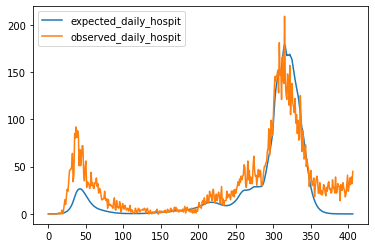

In [19]:
plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
plt.legend()
plt.show()

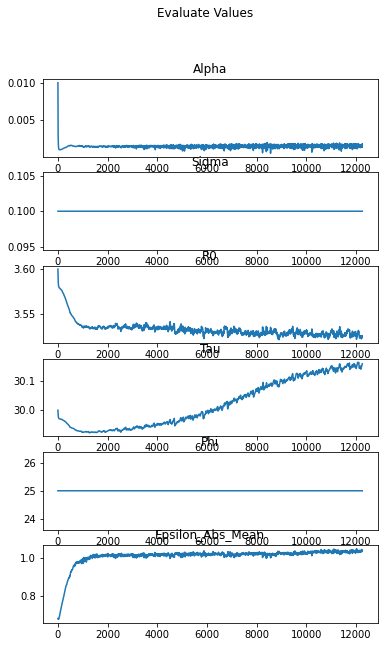

In [20]:
fig, axs = plt.subplots(6)
fig.suptitle(f'Evaluate Values')
fig.set_figheight(10)
axs[0].plot(alpha_vis)
axs[0].title.set_text('Alpha')
axs[1].plot(sigma_vis)
axs[1].title.set_text('Sigma')
axs[2].plot(R0_vis)
axs[2].title.set_text('R0')
axs[3].plot(tau_vis)
axs[3].title.set_text('Tau')
axs[4].plot(phi_vis)
axs[4].title.set_text('Phi')
axs[5].plot(epsilon_mean_vis)
axs[5].title.set_text('Epsilon_Abs_Mean')
plt.show()

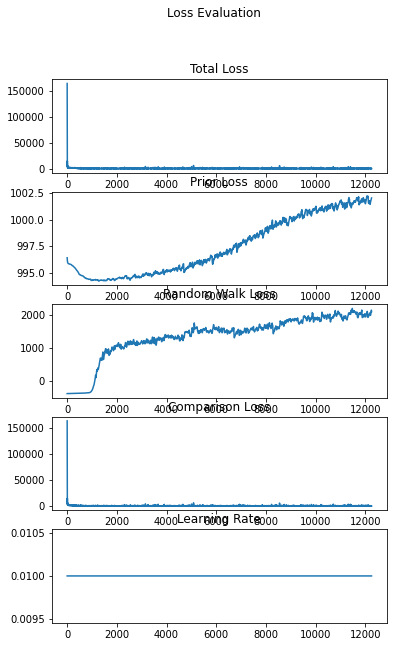

In [21]:
fig, axs = plt.subplots(5)
fig.suptitle(f'Loss Evaluation')
fig.set_figheight(10)
axs[0].plot(loss_vis)
axs[0].title.set_text('Total Loss')
axs[1].plot(prior_loss_vis)
axs[1].title.set_text('Prior Loss')
axs[2].plot(rw_loss_vis)
axs[2].title.set_text('Random Walk Loss')
axs[3].plot(comp_loss_vis)
axs[3].title.set_text('Comparison Loss')
axs[4].plot(learning_rate_vis)
axs[4].title.set_text('Learning Rate')
plt.show()